# Data exploration

### Utils

In [59]:
# import utils
import cv2
import os 
import sys
import matplotlib.pyplot as plt 
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations.geometric.resize import Resize

# import functions
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import *


### Paths

In [60]:
images_path = '../data/processed/images'
labels_path = '../data/processed/labels'

## Data correction

In [61]:
# Check if every image has a label
check_images_labels(images_path=images_path, labels_path=labels_path)

# Number of images
n_images = get_num_images(images_path=images_path)
print(f"Number of images: {n_images}")

All images have corresponding labels
Number of images: 1480


## Loading images

In [62]:
def draw_bounding_box(image_path, bounding_boxes):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    img_height, img_width = image.shape[:2]

    # Define the colors
    colors = {
        0: (255, 0, 0),
        1: (0, 255, 0),
        2: (0, 0, 255),
        3: (255, 255, 0),
        4: (255, 0, 255),
        5: (0, 255, 255),
    }

    for bbox in bounding_boxes:
        class_id, x_center, y_center, width, height = bbox

        # Convert the coordinates to absolute values
        x_center, y_center = int(x_center * img_width), int(y_center * img_height)
        width, height = int(width * img_width), int(height * img_height)

        # Calculate the top-left and bottom-right corner of the bounding box
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)

        # Class color
        color = colors[class_id]

        # Draw the bounding box
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        # Add the class name
        cv2.putText(
            image, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2
        )

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

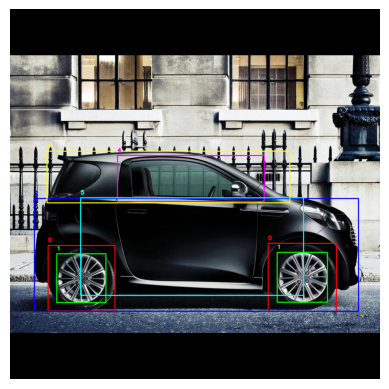

In [63]:
image_path = '../data/processed/images/A_Ast_01.jpg'
image_label_path = '../data/processed/labels/A_Ast_01.txt'

bounding_boxes = []
with open(image_label_path, 'r') as file:
    for line in file:
        class_id, x_center, y_center, width, height = line.strip().split()
        bounding_boxes.append([int(class_id), float(x_center), float(y_center), float(width), float(height)])

draw_bounding_box(image_path, bounding_boxes)


# Convert LabelME JSON labels into COCO formats

In [64]:
labelme_dir = "../data/with_labels/json"
coco_labels_file = "../data/with_labels/labels/coco_annotations.json"
labelme_to_coco(labelme_dir, coco_labels_file)

COCO annotations saved to ../data/with_labels/labels/coco_annotations.json


## Visualization COCO Format

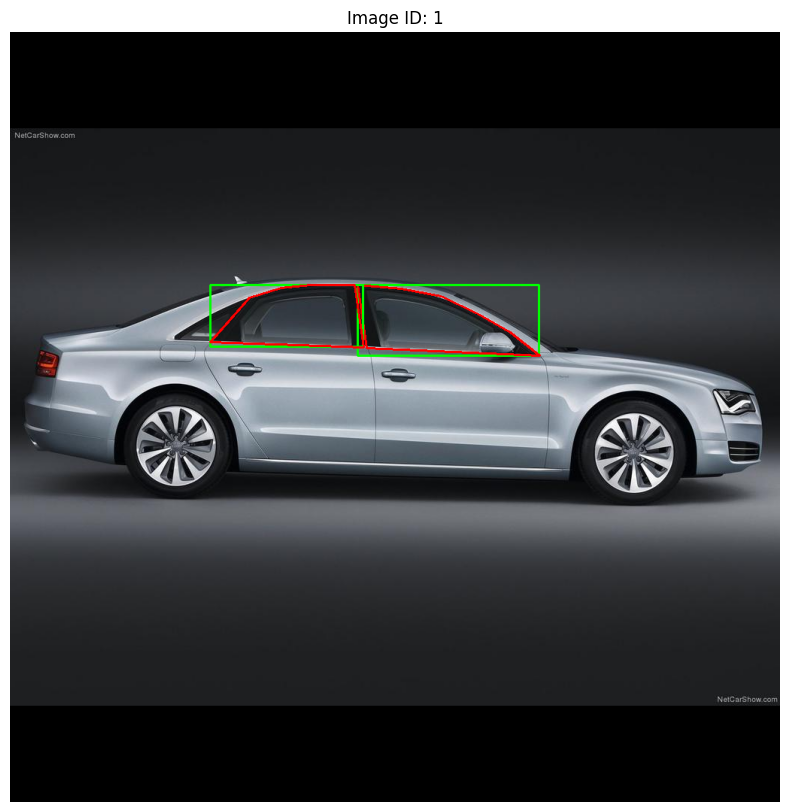

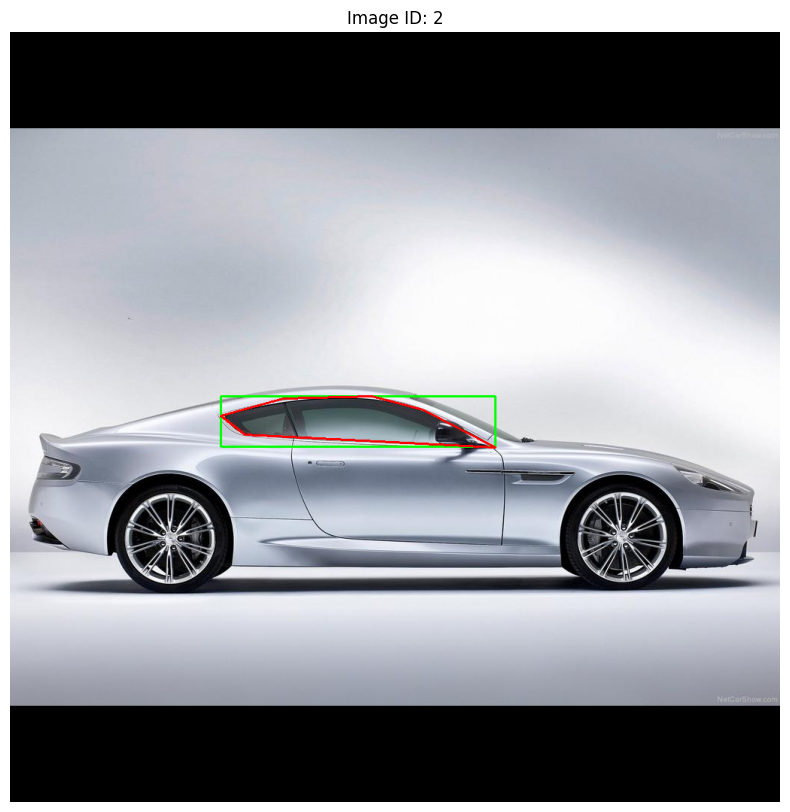

In [72]:
import json
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_coco_annotations(coco_json, images_dir, num_samples=5):
    """
    Visualizes COCO annotations by overlaying bounding boxes and segmentation masks on images.
    
    Parameters:
        coco_json (str): Path to the COCO JSON file.
        images_dir (str): Directory containing the images.
        num_samples (int): Number of images to visualize.
    """
    # Load COCO JSON
    with open(coco_json, 'r') as f:
        coco_data = json.load(f)

    # Map image IDs to image metadata
    image_dict = {img["id"]: img for img in coco_data["images"]}

    # Map annotations by image_id
    annotations_by_image = {}
    for ann in coco_data["annotations"]:
        image_id = ann["image_id"]
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)

    # Visualize a subset of images
    for img_id, img_data in list(image_dict.items())[:num_samples]:
        img_path = Path(images_dir) / img_data["file_name"]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

        # Overlay annotations
        if img_id in annotations_by_image:
            for ann in annotations_by_image[img_id]:
                # Draw bounding box
                bbox = ann["bbox"]
                x_min, y_min, width, height = map(int, bbox)
                x_max, y_max = x_min + width, y_min + height
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

                # Draw segmentation (if available)
                if "segmentation" in ann:
                    points = ann["segmentation"][0]
                    points = [(int(points[i]), int(points[i + 1])) for i in range(0, len(points), 2)]
                    for i in range(len(points)):
                        cv2.line(image, points[i], points[(i + 1) % len(points)], color=(255, 0, 0), thickness=2)

        # Display the image with annotations
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.title(f"Image ID: {img_id}")
        plt.axis("off")
        plt.show()

# Example usage
images_dir = "../data/with_labels/images"        # Path to your image directory
visualize_coco_annotations(coco_labels_file, images_dir, num_samples=2)


# Data Preprocessing

## Convert LabelMe labels to mask

In [73]:
images_dir = "../data/with_labels/images"  # Path to normal images
labelme_dir = "../data/with_labels/json"  # Directory containing LabelMe JSON files
output_mask_dir = "../data/with_labels/masks"  # Directory of masks
output_augmentations_dir = "../data/with_labels/augmented"  # Directory to save augmented images

In [74]:

def create_masks(labelme_dir, output_mask_dir):
    """
    Converts LabelMe JSON annotations to binary masks.

    Parameters:
        labelme_dir (str): Directory containing LabelMe JSON files.
        output_mask_dir (str): Directory to save generated masks.
    """
    os.makedirs(output_mask_dir, exist_ok=True)

    for json_file in Path(labelme_dir).glob("*.json"):
        with open(json_file, "r") as f:
            label_data = json.load(f)

        # Get image dimensions
        img_height = label_data["imageHeight"]
        img_width = label_data["imageWidth"]

        # Create an empty mask
        mask = np.zeros((img_height, img_width), dtype=np.uint8)

        # Add polygons to the mask
        for shape in label_data["shapes"]:
            if shape["label"] == "window":  # Use only "window" labels
                points = np.array(shape["points"], dtype=np.int32)
                cv2.fillPoly(mask, [points], color=1)

        # Save the mask
        mask_name = Path(label_data["imagePath"]).stem + ".png"
        mask_path = os.path.join(output_mask_dir, mask_name)
        cv2.imwrite(mask_path, mask * 255)  # Convert to 0-255 scale for saving as PNG

    print(f"Masks saved")



In [75]:
create_masks(labelme_dir, output_mask_dir)

Masks saved


## Masks visualization

In [69]:
def visualize_mask(image_path, mask_path):
    """
    Visualizes the original image and its corresponding mask.

    Parameters:
        image_path (str): Path to the input image.
        mask_path (str): Path to the binary mask.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.show()

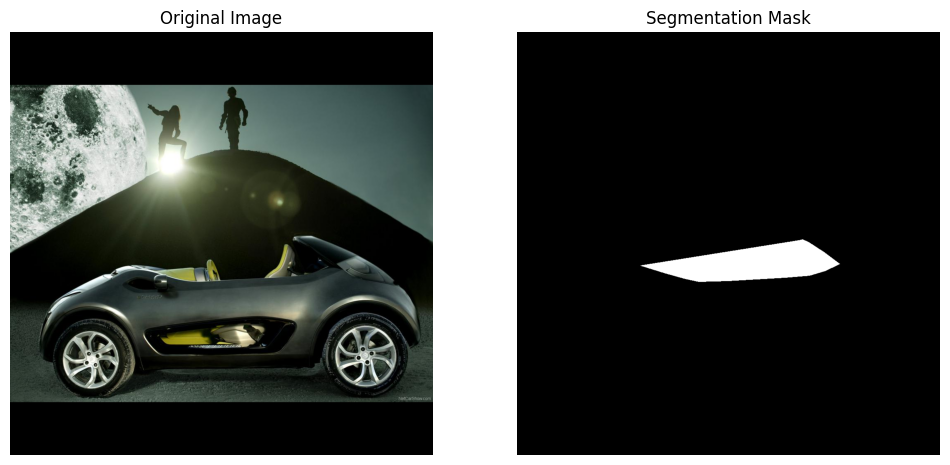

In [70]:
visualize_mask("../data/with_labels/images/A_Cit_01.jpg", "../data/with_labels/masks/A_Cit_01.png")

## Data augmentation

### Define the transformations for segmentation

In [33]:
def augment_dataset(images_dir, masks_dir, output_dir, num_augmented=5):
    """
    Augments an entire dataset of images and corresponding masks for segmentation tasks.

    Parameters:
        images_dir (str): Directory containing input images.
        masks_dir (str): Directory containing input masks.
        output_dir (str): Directory to save augmented images and masks.
        num_augmented (int): Number of augmented copies to generate for each image-mask pair.
    """
    transform = A.Compose(
        [
            A.HorizontalFlip(p=0.5),  # Flips image and mask horizontally.
            A.RandomBrightnessContrast(p=0.2),  # Adjust brightness and contrast of the image.
            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.05,
                rotate_limit=15,
                border_mode=0,  # Padding ensures dimensions remain consistent.
                p=0.5,
            ),
            A.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Adds slight blurring.
            A.HueSaturationValue(
                hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3
            ),  # Changes hue, saturation, and value.
            A.Resize(1024, 1024, always_apply=True),  # Ensures image and mask are resized consistently.
        ]
    )

    # Create output directories
    output_images_dir = Path(output_dir) / "images"
    output_masks_dir = Path(output_dir) / "masks"
    output_images_dir.mkdir(parents=True, exist_ok=True)
    output_masks_dir.mkdir(parents=True, exist_ok=True)

    # Process all images and masks
    for image_path in Path(images_dir).glob("*.jpg"):
        mask_path = Path(masks_dir) / f"{image_path.stem}.png"
        if not mask_path.exists():
            print(f"Mask for {image_path.name} not found. Skipping.")
            continue

        # Load image and mask
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        for i in range(num_augmented):
            # Apply augmentation
            transformed = transform(image=image, mask=mask)
            aug_image = transformed["image"]
            aug_mask = transformed["mask"]

            # Save augmented image and mask
            aug_image_name = f"{image_path.stem}_aug_{i}.jpg"
            aug_mask_name = f"{mask_path.stem}_aug_{i}.png"
            cv2.imwrite(
                str(output_images_dir / aug_image_name),
                cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR),
            )
            cv2.imwrite(str(output_masks_dir / aug_mask_name), aug_mask)

    print(f"Augmented dataset saved in {output_dir}")

In [34]:
augment_dataset(images_dir, output_mask_dir, output_augmentations_dir, num_augmented=5)

Augmented dataset saved in ../data/with_labels/augmented


### Visualize augmented images and masks

In [36]:
def visualize_augmented_data(image_dir, mask_dir, num_samples=5):
    """
    Visualizes a few augmented image-mask pairs.

    Parameters:
        image_dir (str): Directory containing augmented images.
        mask_dir (str): Directory containing augmented masks.
        num_samples (int): Number of samples to visualize.
    """
    image_paths = sorted(Path(image_dir).glob("*.jpg"))[:num_samples]
    mask_paths = sorted(Path(mask_dir).glob("*.png"))[:num_samples]

    for img_path, mask_path in zip(image_paths, mask_paths):
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Augmented Image: {img_path.name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Augmented Mask: {mask_path.name}")
        plt.axis("off")

        plt.show()

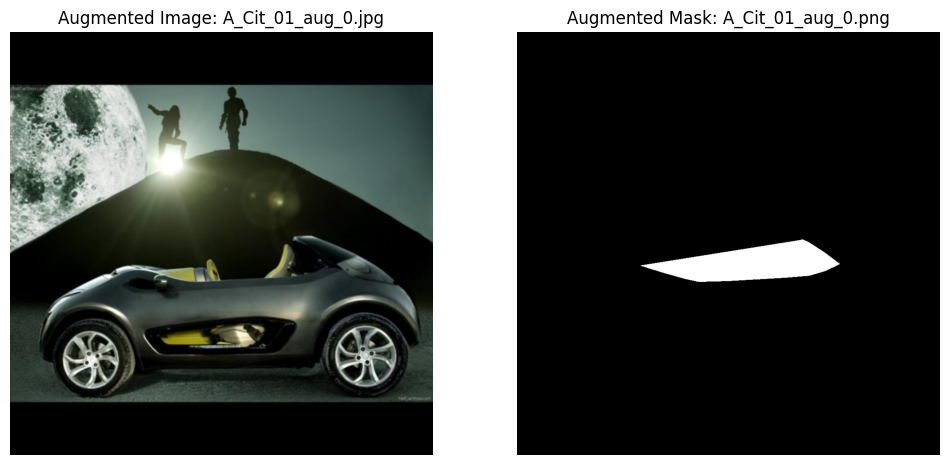

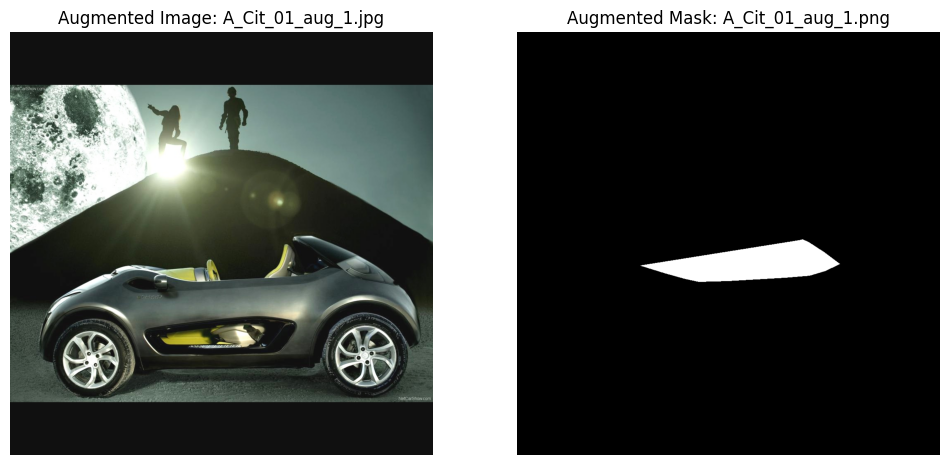

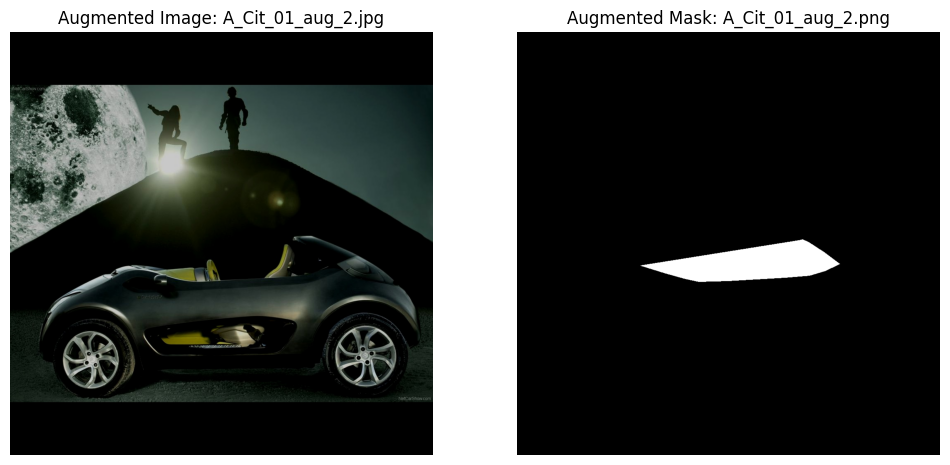

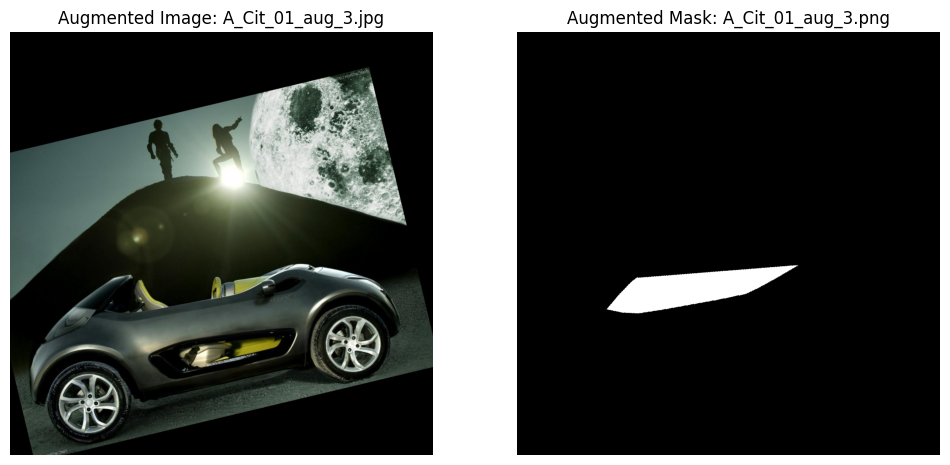

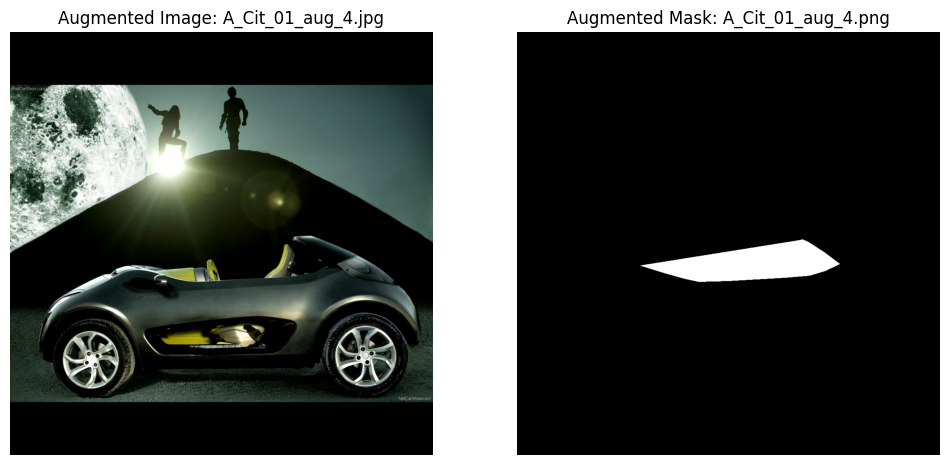

In [37]:
augmented_images_dir = "../data/with_labels/augmented/images"
augmented_masks_dir = "../data/with_labels/augmented/masks"
visualize_augmented_data(augmented_images_dir, augmented_masks_dir)